In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from PIL import Image, ImageDraw, ImageFont
from subprocess import check_call

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

pd.options.display.max_seq_items = 200
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
train = pd.read_csv('/Users/tWo/Documents/Project/Titanic/train.csv')
test = pd.read_csv('/Users/tWo/Documents/Project/Titanic/test.csv')

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#show info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
#giving shape
train.shape

(891, 12)

In [5]:
#drop unnecessary features
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [6]:
#see if any NAs, and get count
train.iloc[:,7].isnull().any()
train.isnull().values.any()
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
#fill NAs with median Fare
#print(test.isnull().sum())
test['Fare'].fillna(test['Fare'].median(), inplace=True)
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [8]:
#get stats summary
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


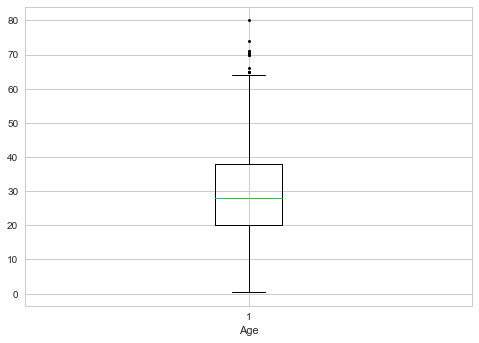

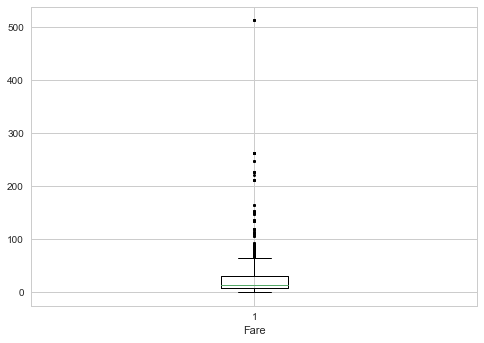

In [9]:
#plot Age ignoring NAs
tempAge = train['Age'].dropna()
tempAge.isnull().values.any()

#plot Fare
plt.boxplot(tempAge, sym='k.')
plt.subplot().set_xlabel('Age')
plt.show()
plt.boxplot(train['Fare'], sym='k.')
plt.subplot().set_xlabel('Fare')
plt.show()

In [10]:
#get NA's index and see if there is pattern
missA = train.loc[train.Age.isnull()].index
#missA

missB = train.loc[train.Cabin.isnull()].index
#missB

#train.loc[missA,['Age', 'Cabin']].head(20)
#train.loc[missB,['Age', 'Cabin']].head(20)

In [11]:
#get index of NA and show
train.loc[train.Embarked.isnull()].index

train['Embarked'][58:63]
train['Embarked'][825:831]

#impute NAs with S
embark_mode = train['Embarked'].astype('category').mode()
print(embark_mode)
train['Embarked'] = train['Embarked'].fillna('S')
train['Embarked'].isnull().values.any()

0    S
dtype: category
Categories (3, object): [C, Q, S]


False

In [12]:
#see survival rate based on Class
groupClass = train.groupby('Pclass')
groupClass.mean()

,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,0.629630,38.233441,0.416667,0.356481,84.154687
2,0.472826,29.877630,0.402174,0.380435,20.662183
3,0.242363,25.140620,0.615071,0.393075,13.675550


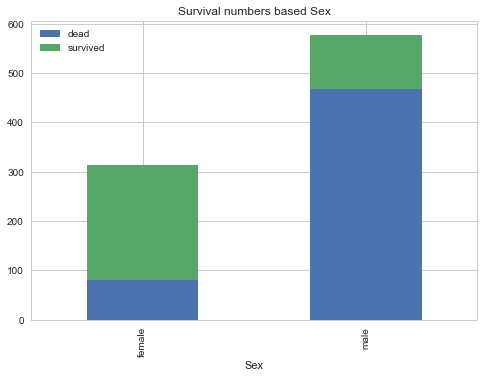

In [13]:
#histogram based on Sex
groupSex = train.groupby('Sex')
sexSuvived = groupSex.sum()
sexSuvived

dead = groupSex.count().iloc[:,0] - groupSex.sum().iloc[:,0]
dead = dead.to_frame()
dead['survived'] = sexSuvived.iloc[:,0]
dead.columns = ['dead', 'survived']
dead[['dead', 'survived']].plot(kind='bar', stacked=True)
plt.title('Survival numbers based Sex')
plt.show()

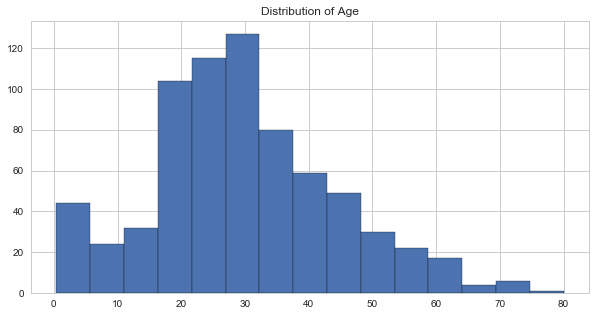

In [14]:
#distribution of Age
plt.figure(1, figsize=(10,5))
plt.hist(tempAge, bins=15, edgecolor='black')
plt.title('Distribution of Age')
plt.show()

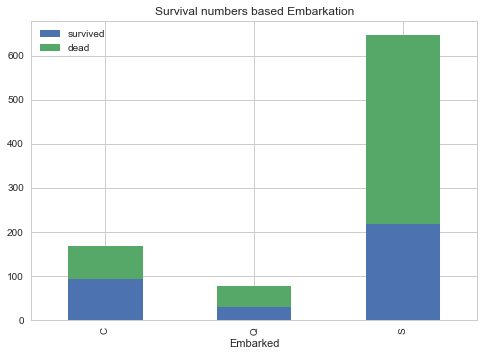

In [15]:
#histogram based on embarkation
embark = train.groupby(['Embarked']).count()
embark = embark.iloc[:,0]
embark = pd.DataFrame(embark)
embark['survived'] = train.groupby(['Embarked']).sum().iloc[:,0]
embark.rename(columns={'Survived':'sum'}, inplace=True)
embark['dead'] = embark.iloc[:,0] - embark.iloc[:,1]
embark[['survived', 'dead']].plot(kind='bar', stacked=True)
plt.title('Survival numbers based Embarkation')
plt.show()

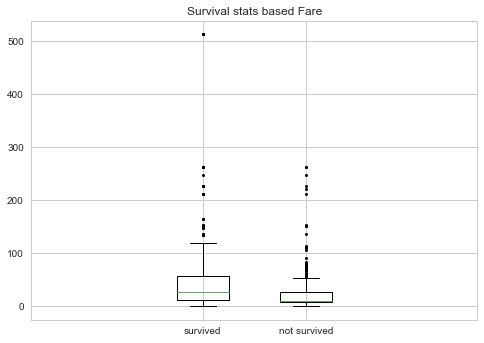

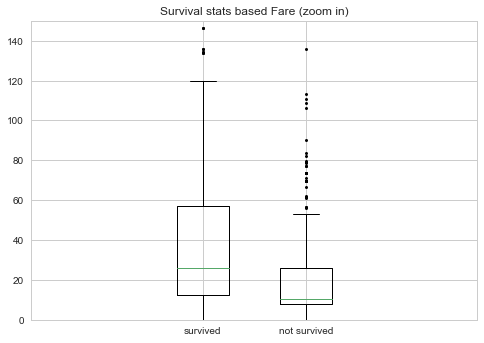

In [16]:
#plot boxplot for Fare related to survival
fare_survived = train['Fare'][train['Survived'] == 1]
fare_not_survived = train['Fare'][train['Survived'] == 0]
fare_not_survived.count() + fare_survived.count()

fare_survived = np.array(fare_survived)
fare_not_survived = np.array(fare_not_survived)
fig1 = plt.figure(1, )
ax = fig1.add_subplot(111)
plt.boxplot([fare_survived,fare_not_survived], positions=[2,2.3], sym='k.')
ax.set_xticklabels(['survived', 'not survived'])
plt.title('Survival stats based Fare')
plt.show()

#zoom in ignoring outliers
fig2 = plt.figure(1)
ax = fig2.add_subplot(111)
plt.boxplot([fare_survived, fare_not_survived], positions=[2,2.3], sym='k.')
ax.set_xticklabels(['survived', 'not survived'])
plt.ylim(0,150)
plt.title('Survival stats based Fare (zoom in)')
plt.show()

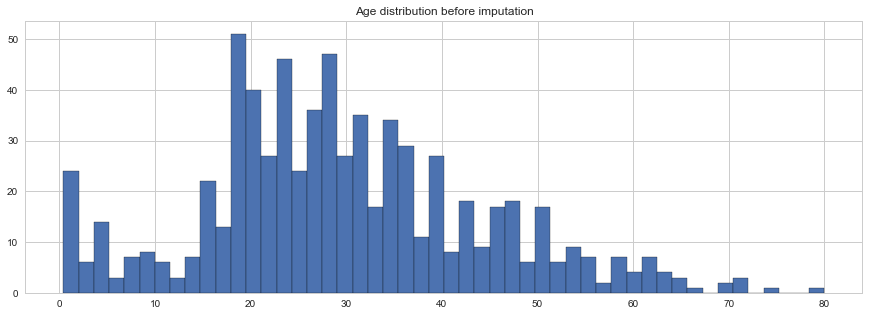

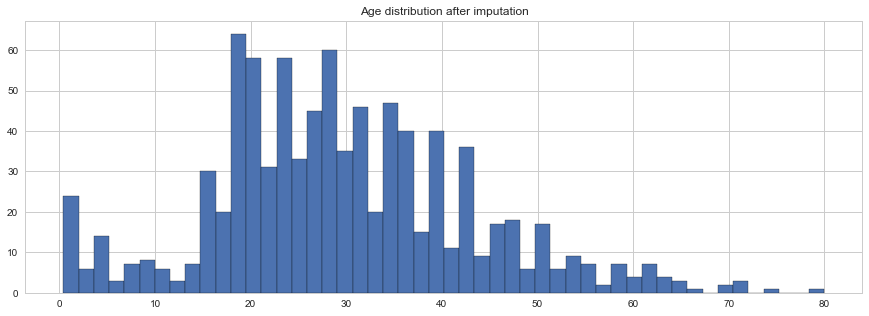

In [17]:
#plot Age before imputation
plt.figure(1, figsize=(15,5))
plt.hist(tempAge, bins=50, edgecolor='black')
plt.title('Age distribution before imputation')
plt.show()

#Age imputation and plot
na_age_train = train['Age'].isnull().sum()
avg_train = train['Age'].mean()
std_train = train['Age'].std()
na_age_test = test['Age'].isnull().sum()
avg_test = test['Age'].mean()
std_test = test['Age'].std()

rand_age_train = np.random.randint(avg_train - std_train, avg_train + std_train, size=na_age_train)
rand_age_test = np.random.randint(avg_test - std_test, avg_test + std_test, size=na_age_test)

train['Age'][np.isnan(train['Age'])] = rand_age_train
test['Age'][np.isnan(test['Age'])] = rand_age_test
test['Age'].isnull().sum()

plt.figure(1, figsize=(15,5))
plt.hist(train['Age'], bins=50, edgecolor='black')
plt.title('Age distribution after imputation')
plt.show()

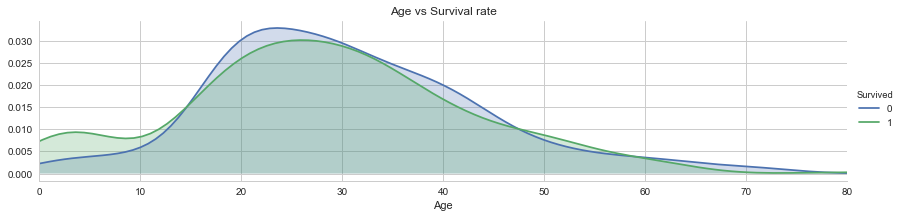

In [18]:
#plot Age vs. Survival
agemap = sns.FacetGrid(train, hue='Survived', aspect=4)
agemap.map(sns.kdeplot, 'Age', shade=True)
agemap.set(xlim=(0, train['Age'].max()))
agemap.add_legend()
plt.title('Age vs Survival rate')
plt.show()

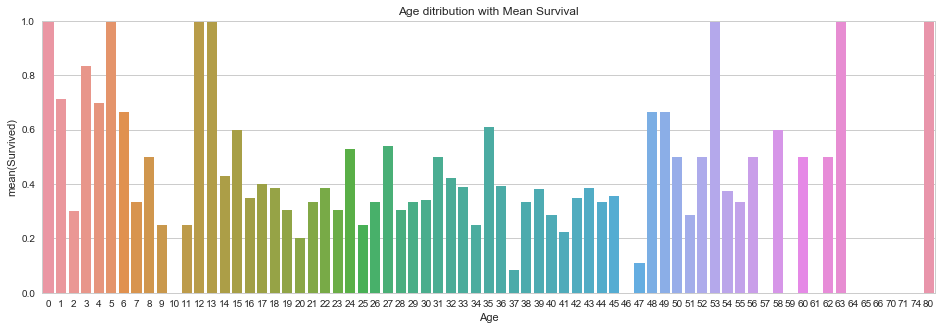

In [19]:
#Survival rate vs. Age
intage = train['Age'].astype(int)
intage = intage.to_frame()
intage['Survived'] = train['Survived']
avgage = intage.groupby(['Age'], as_index=False).mean()
plt.figure(1, figsize=(16,5))
plt.ylim(0,1)
sns.barplot(x='Age', y='Survived', data=avgage)
plt.title('Age ditribution with Mean Survival')
plt.show()

In [20]:
# drop cabin
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)
list(train)

#create Family=sib+par with 0 or 1
train['Family'] = train['SibSp'] + train['Parch']
train['Family'].loc[train['Family'] == 0] = 0
train['Family'].loc[train['Family'] != 0] = 1
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

test['Family'] = test['SibSp'] + test['Parch']
test['Family'].loc[test['Family'] == 0] = 0
test['Family'].loc[test['Family'] != 0] = 1
test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

#show features left and sample of Family
print(list(train))
train['Family'].head(5)

['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family']


0    1
1    1
2    0
3    1
4    0
Name: Family, dtype: int64

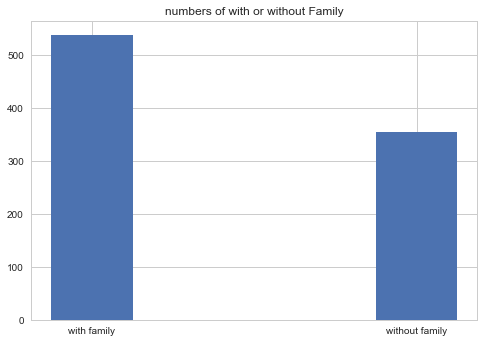

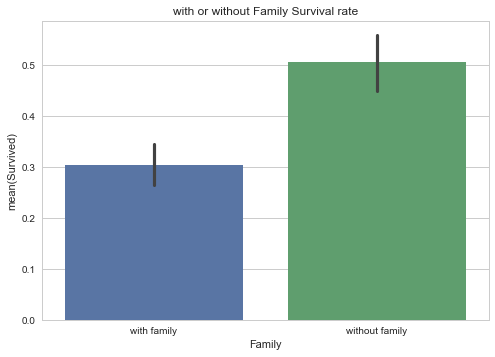

In [21]:
#count for with or without Family
plt.hist(x='Family', bins=5, data=train)
plt.xticks([0.1,0.9], ['with family', 'without family'])
plt.title('numbers of with or without Family')
plt.show()

#Survival rate based on Family
sns.barplot(x='Family', y='Survived', data=train)
plt.xticks([0,1], ['with family', 'without family'])
plt.title('with or without Family Survival rate')
plt.show()

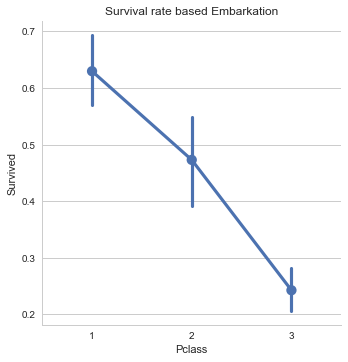

In [22]:
#Survival rate based on Class
sns.factorplot('Pclass','Survived',order=[1,2,3], data=train,size=5)
plt.title('Survival rate based Embarkation')
plt.show()

#create dummy for Class
class_dummy_train = pd.get_dummies(train['Pclass'])
class_dummy_train.columns = ['Class1', 'Class2', 'Class3']
train = train.join(class_dummy_train)
train.drop('Pclass', axis=1, inplace=True)

class_dummy_test = pd.get_dummies(test['Pclass'])
class_dummy_test.columns = ['Class1', 'Class2', 'Class3']
test = test.join(class_dummy_test)
test.drop('Pclass', axis=1, inplace=True)

In [23]:
#drop for test set as accordance with train
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

#create dummy for Sex
train['Sex'].loc[train['Sex'] == 'male'] = 1
train['Sex'].loc[train['Sex'] == 'female'] = 0
train['Sex'] = pd.to_numeric(train['Sex'], errors='coerce')

test['Sex'].loc[test['Sex'] == 'male'] = 1
test['Sex'].loc[test['Sex'] == 'female'] = 0
test['Sex'] = pd.to_numeric(test['Sex'], errors='coerce')

#create dummy for Embarkation
embark_dummy = pd.get_dummies(train['Embarked'])
embark_dummy.columns = ['Embark_C', 'Embark_Q', 'Embark_S']
train = train.join(embark_dummy)
train = train.drop('Embarked', axis=1)

embark_dummy_t = pd.get_dummies(test['Embarked'])
embark_dummy_t.columns = ['Embark_C', 'Embark_Q', 'Embark_S']
test = test.join(embark_dummy_t)
test = test.drop('Embarked', axis=1)

#assign x and y for model building
y_train = train['Survived']
x_train = train.drop('Survived', axis=1)

x_test = test.copy()

In [24]:
# logistic regression
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)
y_final = y_pred.copy()
print('Train data accuracy rate is:',log_reg.score(x_train, y_train))

Train data accuracy rate is: 0.800224466891


In [25]:
y_test = pd.read_csv('/Users/tWo/Documents/Project/Titanic/gender_submission.csv')
y_test['y_pred'] = y_pred

print('Test data accuracy rate is:', len(y_test[y_test['Survived'] == y_test['y_pred']])/len(y_pred))
y_test.head(10)

Test data accuracy rate is: 0.9449760765550239


,PassengerId,Survived,y_pred
0,892,0,0
1,893,1,0
2,894,0,0
3,895,0,0
4,896,1,1
5,897,0,0
6,898,1,1
7,899,0,0
8,900,1,1
9,901,0,0


In [26]:
# svm
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Train data accuracy is:', svm.score(x_train, y_train))

y_test['y_pred'] = y_pred
print('Test data accuracy rate is:', len(y_test[y_test['Survived'] == y_test['y_pred']])/len(y_pred))
#y_test.head(10)

Train data accuracy is: 0.875420875421
Test data accuracy rate is: 0.6578947368421053


In [27]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print('Train data accuracy is:', svm.score(x_train, y_train))

y_test['y_pred'] = y_pred
print('Test data accuracy rate is:', len(y_test[y_test['Survived'] == y_test['y_pred']])/len(y_pred))
#y_test.head(10)

Train data accuracy is: 0.875420875421
Test data accuracy rate is: 0.8253588516746412


In [28]:
#create a data frame for coefficients
coef = pd.DataFrame(train.columns.delete(0))
coef.columns = ['Features']
coef['Coefficients'] = pd.Series(log_reg.coef_[0])
coef.loc[-1] = ['Intercept', log_reg.intercept_[0]]
coef.index = coef.index + 1
coef.sort()

,Features,Coefficients
0,Intercept,1.404243
1,Sex,-2.446460
2,Age,-0.030299
3,Fare,0.000968
4,Family,-0.020012
5,Class1,1.452227
6,Class2,0.605101
7,Class3,-0.653085
8,Embark_C,0.655586
9,Embark_Q,0.602568


In [29]:
#create a csv for submission
submission = pd.DataFrame({
    'PassengerId': y_test['PassengerId'],
    'Survived': y_final
})
submission.to_csv('Final_Result', sep=',', index=False)

In [50]:
#create classification tree
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)

with open('tree.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree, out_file=f, max_depth=3, impurity = True, 
                              feature_names=list(x_train), class_names=['Died','Survived'], rounded=True, 
                              filled=True)

#check_call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
#not wokring

FileNotFoundError: [Errno 2] No such file or directory: 'dot'